## Exploratory data analysis on SRQ data

In [1]:
import pandas as pd
import scipy.stats as stats
from scipy.stats import skew, kurtosis
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv('Datasets/FlightsByDay-SRQ-2025_07_21_09_49_46.csv')
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13279 entries, 0 to 13278
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 13279 non-null  datetime64[ns]
 1   Flight               13279 non-null  object        
 2   Destination Airport  13279 non-null  object        
 3   Airline              13279 non-null  object        
 4   Boarded              13279 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 518.8+ KB


In [3]:
df['Boarded'].describe()

count    13279.000000
mean       118.774607
std         50.100440
min          1.000000
25%         89.000000
50%        129.000000
75%        157.000000
max        392.000000
Name: Boarded, dtype: float64

In [4]:
print("Skew:", skew(df['Boarded']))
print("Kurtosis:", kurtosis(df['Boarded']))

Skew: -0.5474465530665478
Kurtosis: 0.4260362857446749


In [5]:
# remove flights with less than 10 passengers and greater than 250 passengers

df = df[(df['Boarded'] >= 10) & (df['Boarded'] <= 250)]

<Axes: xlabel='Boarded'>

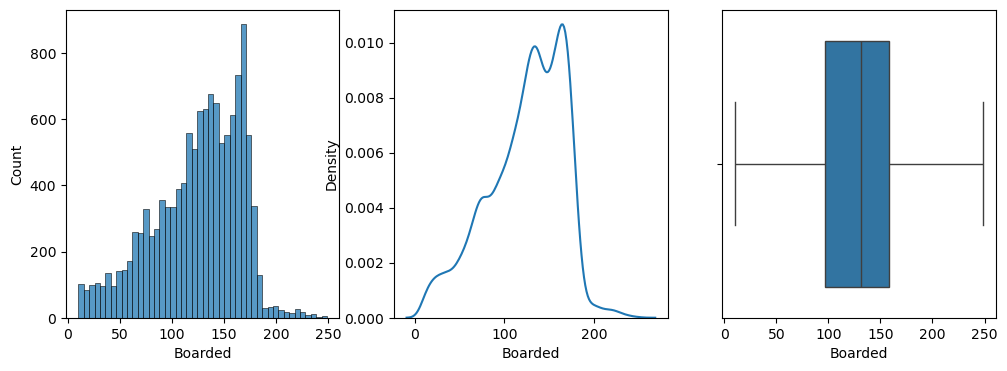

In [6]:
fig, axes = plt.subplots(1,3, figsize=(12,4))
sns.histplot(df['Boarded'], ax=axes[0])
sns.kdeplot(df['Boarded'], ax=axes[1])
sns.boxplot(x=df['Boarded'], ax=axes[2])

IQR outliers: 0 rows
Z‑score outliers: 0 rows


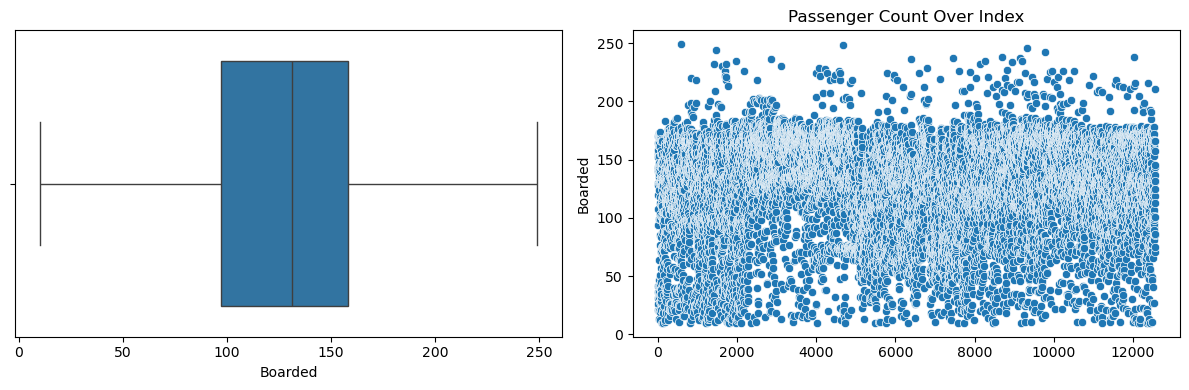

In [7]:
# 3a) IQR rule
q1, q3 = df['Boarded'].quantile([0.25, 0.75])
iqr = q3 - q1
lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
outliers_iqr = df[(df['Boarded'] < lower) | (df['Boarded'] > upper)]
print(f"IQR outliers: {len(outliers_iqr)} rows")

# 3b) Z‑score
z_scores = stats.zscore(df['Boarded'].fillna(df['Boarded'].mean()))
outliers_z = df[np.abs(z_scores) > 3]
print(f"Z‑score outliers: {len(outliers_z)} rows")

# 3c) Visualize
fig, ax = plt.subplots(1, 2, figsize=(12,4))
sns.boxplot(x='Boarded', data=df, ax=ax[0])
sns.scatterplot(x=range(len(df)), y='Boarded', data=df, ax=ax[1])
ax[1].set_title('Passenger Count Over Index')
plt.tight_layout()

In [8]:
len(df[df['Boarded'] > 250])

0

In [9]:

bins_with_rates = [
    (180, 190, 5),
    (190, 200, 25),
    (200, 250, 20),
    (250, 300, 100),   
    (300, 350, 50),   
    (350, 400, 25),   
]

augmented_parts = [df]  # start with the original data

# 2) loop over each bin specification
for low, high, n_dup in bins_with_rates:
    # select rows in [low, high)
    subset = df[(df['Boarded'] >= low) & (df['Boarded'] < high)]
    if subset.empty or n_dup <= 0:
        continue
    
    # duplicate by concatenating the subset n_dup times
    dup = pd.concat([subset] * n_dup, ignore_index=True)
    
    # add tiny jitter so Boarded values aren’t exact clones
    dup['Boarded'] += np.random.normal(
        loc=0.0,
        scale=1e-6,
        size=len(dup)
    )
    
    augmented_parts.append(dup)

# 3) recombine everything
df_augmented = pd.concat(augmented_parts, ignore_index=True)



In [10]:
len(df)

12560

In [11]:
df_augmented

,Date,Flight,Destination Airport,Airline,Boarded
0,2023-09-14,AA2679,DFW,AA,130.000000
1,2023-09-14,G41150,PIT,G4,155.000000
2,2023-09-14,G4183,ABE,G4,152.000000
3,2023-09-14,G4218,AVL,G4,144.000000
4,2023-09-14,G42977,CAK,G4,143.000000
...,...,...,...,...,...
18090,2025-06-30,WN155,BWI,WN,212.999999
18091,2025-07-01,WN155,BWI,WN,215.999999
18092,2025-07-05,G42979,CVG,G4,205.000000
18093,2025-07-14,F91288,CLE,F9,216.000000


<Axes: xlabel='Boarded'>

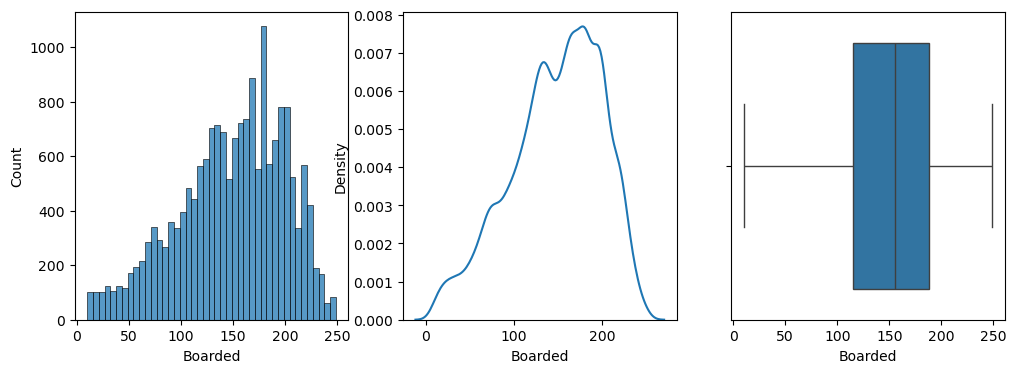

In [12]:
fig, axes = plt.subplots(1,3, figsize=(12,4))
sns.histplot(df_augmented['Boarded'], ax=axes[0])
sns.kdeplot(df_augmented['Boarded'], ax=axes[1])
sns.boxplot(x=df_augmented['Boarded'], ax=axes[2])

In [13]:
# Extract time-based features
#df['Hour'] = df['Flight Time'].dt.hour
df['Day_of_Week'] = df['Date'].dt.dayofweek  # 0=Monday, 6=Sunday
df['Month'] = df['Date'].dt.month
df['Day_of_Month'] = df['Date'].dt.day

# Create time-based categories
#df['Time_Category'] = pd.cut(df['Hour'], 
                           #bins=[0, 6, 12, 18, 24], 
                           #labels=['Night', 'Morning', 'Afternoon', 'Evening'])

# Encode categorical variables (Try: target encoding instead of categorical)
label_encoders = {}
categorical_columns = ['Destination Airport', 'Airline']

for col in categorical_columns:
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le



In [14]:
df['day_sin'] = np.sin(2*np.pi*df['Day_of_Month']/31)
df['day_cos'] = np.cos(2*np.pi*df['Day_of_Month']/31)

# Month (1–12) → convert to 0–11 by subtracting 1, then encode
df['month_sin'] = np.sin(2 * np.pi * (df['Month'] - 1) / 12)
df['month_cos'] = np.cos(2 * np.pi * (df['Month'] - 1) / 12)

# Day of Week → if 0=Monday…6=Sunday, just divide by 7
df['dow_sin'] = np.sin(2 * np.pi * df['Day_of_Week'] / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['Day_of_Week'] / 7)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12560 entries, 0 to 13278
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Date                         12560 non-null  datetime64[ns]
 1   Flight                       12560 non-null  object        
 2   Destination Airport          12560 non-null  object        
 3   Airline                      12560 non-null  object        
 4   Boarded                      12560 non-null  int64         
 5   Day_of_Week                  12560 non-null  int32         
 6   Month                        12560 non-null  int32         
 7   Day_of_Month                 12560 non-null  int32         
 8   Destination Airport_encoded  12560 non-null  int32         
 9   Airline_encoded              12560 non-null  int32         
 10  day_sin                      12560 non-null  float64       
 11  day_cos                      12560 non-null  f

In [15]:
route_stats = df.groupby(['Airline','Destination Airport'])['Boarded'].agg([
    ('route_mean','mean'),
    ('route_median','median'),
    ('route_std','std'),
]).reset_index()
df = df.merge(route_stats, on=['Airline','Destination Airport'], how='left')
df

,Date,Flight,Destination Airport,Airline,Boarded,Day_of_Week,Month,Day_of_Month,Destination Airport_encoded,Airline_encoded,day_sin,day_cos,month_sin,month_cos,dow_sin,dow_cos,route_mean,route_median,route_std
0,2023-09-14,AA2679,DFW,AA,130,3,9,14,23,0,0.299363,-0.954139,-8.660254e-01,-0.5,0.433884,-0.900969,96.518750,99.5,51.749150
1,2023-09-14,G41150,PIT,G4,155,3,9,14,60,5,0.299363,-0.954139,-8.660254e-01,-0.5,0.433884,-0.900969,148.430034,162.0,34.409989
2,2023-09-14,G4183,ABE,G4,152,3,9,14,0,5,0.299363,-0.954139,-8.660254e-01,-0.5,0.433884,-0.900969,150.730769,157.0,23.763546
3,2023-09-14,G4218,AVL,G4,144,3,9,14,6,5,0.299363,-0.954139,-8.660254e-01,-0.5,0.433884,-0.900969,126.549550,133.5,33.820457
4,2023-09-14,G42977,CAK,G4,143,3,9,14,14,5,0.299363,-0.954139,-8.660254e-01,-0.5,0.433884,-0.900969,152.762452,160.0,22.801929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12555,2025-07-20,WN4409,IND,WN,71,6,7,20,40,9,-0.790776,-0.612106,1.224647e-16,-1.0,-0.781831,0.623490,105.357143,111.0,35.060103
12556,2025-07-20,WN4605,MDW,WN,125,6,7,20,49,9,-0.790776,-0.612106,1.224647e-16,-1.0,-0.781831,0.623490,120.400000,122.0,39.266401
12557,2025-07-20,WN4606,STL,WN,75,6,7,20,71,9,-0.790776,-0.612106,1.224647e-16,-1.0,-0.781831,0.623490,119.448980,128.0,35.404741
12558,2025-07-20,XP306,HVN,XP,132,6,7,20,36,10,-0.790776,-0.612106,1.224647e-16,-1.0,-0.781831,0.623490,121.601604,129.0,37.176401


In [19]:
df
df.to_csv('Datasets/augmented_SRQ_data_v3.csv')

In [17]:
#df[df['Boarded'] > 150]

In [18]:
#len(df[df['Boarded'] > 150])